RAINSTORM

## Automatic analysis
- Use a trained model to automatically label positions

#### Requirements:

- A model previously trained using RAINSTORM 3-Create_models.ipynb
- The position files you'd like to label automatically

---
#### Load the necessary modules

In [11]:
import os
from glob import glob
import pandas as pd
import rainstorm.modeling as rst

---
#### 1. State your project path & thresholds
`base` : The path to the downloaded repository.

`objects` : Name the stationary objects that appear on your data.

`bodyparts` : Name the bodyparts you used for training.

`past` & `future` : If you use a LSTM model, you can set the window size by saying how many frames into the past and how many into the future you want to see.

`broad` : Once you have your window size, we can broaden the window by skipping some frames as we stray further from the present.

In [12]:
# State your path:
base = r'C:\Users\dhers\Desktop\RAINSTORM'
folder_path = os.path.join(base, r'docs\examples\NOR_example')

all_position = glob(os.path.join(folder_path,"T*/position/*position.csv")) # Notice that I added a 'T' on the folder name to avoid trying to label habituation files

# Set the parameters to evaluate behaviours
objects = ['obj_1', 'obj_2']
bodyparts = ['nose', 'L_ear', 'R_ear', 'head', 'neck', 'body']

past, future = 3, 3 # if you use a LSTM model, you can set the window size here
broad = 1.7 # using the same amount of frames, set how broad the window is (skipping frames)
broad_frames = rst.broaden(past, future, broad)
print(f'LSTM frame window: {broad_frames}')

LSTM frame window: [-6, -3, -1, 0, 1, 3, 6]


---
#### 2. Load the chosen model
We need to modify our `model_path` according to what model we want to use

In [13]:
model_path = os.path.join(base, r'docs\models\m_wide\wide_2025-01-07_7w.keras')

from keras.models import load_model
model = load_model(model_path)

# If you choose a LSTM model, set the reshape variable to True:
reshape = True 

---
#### 3. Run the model on all the data selected

In [14]:
rst.create_autolabels(all_position, model, objects, bodyparts, reshaping = reshape, past = past, future = future, broad = broad)

461/461 [==============================] - 8s 13ms/step
Saved autolabels to NOR_TR_C1_A_autolabels.csv
460/460 [==============================] - 6s 13ms/step
Saved autolabels to NOR_TR_C1_B_autolabels.csv
462/462 [==============================] - 6s 13ms/step
Saved autolabels to NOR_TR_C1_C_autolabels.csv
467/467 [==============================] - 6s 13ms/step
Saved autolabels to NOR_TR_C1_D_autolabels.csv
464/464 [==============================] - 6s 12ms/step
Saved autolabels to NOR_TR_C2_A_autolabels.csv
466/466 [==============================] - 6s 12ms/step
Saved autolabels to NOR_TR_C2_B_autolabels.csv
466/466 [==============================] - 6s 13ms/step
Saved autolabels to NOR_TR_C2_C_autolabels.csv
469/469 [==============================] - 6s 13ms/step
Saved autolabels to NOR_TR_C2_D_autolabels.csv
454/454 [==============================] - 6s 13ms/step
Saved autolabels to NOR_TR_C3_A_autolabels.csv
445/445 [==============================] - 6s 12ms/step
Saved autolabels 

---
---
#### A new csv file was created for each video, containing the autolabels.

We can:
- Continue on this notebook and compare the results of the manual, geometric & automatic methods on our example files
- Skip the methods comparison, go straight to Seize_labels.ipynb and use the autolabels to plot the results of the experiment
---

## Compare labels
Lets do a quick recap of what we have done so far...

- Recorded mice exploring objects.
- Analyzed the videos using DeepLabCut, a pose estimation toolkit.
- **Manually labeled** the positions of the mice using the Rainstorm Behavioral Tagger.
- Processed the positions on 1-Prepare_positions.ipynb.
- **Geometrically labeled** the positions on 2-Geometric_labeling.ipynb.
- Trained some Artificial Neural Networks on 3-Create_models.ipynb.
- **Automatically labeled** the positions on 4-Automatic_analysis.ipynb.

And here we are! Now, we can compare manual labels, geolabels & autolabels.

I have labeled the example videos myself using the RAINSTORM labeler tool, and left those manual labels available on the example folder (there is no need to move them).

If you want to see the original videos and label them to compare yourself with the machine, feel free to write: sdhers@fbmc.fcen.uba.ar

In [15]:
TS_position = glob(os.path.join(folder_path,"TS/position/*position.csv")) # Notice that I added 'TS' on the folder name to only compare files from the testing session
TS_manual_labels = glob(os.path.join(folder_path,"TS manual labels/*labels.csv"))
TS_geolabels = glob(os.path.join(folder_path,"TS/geolabels/*labels.csv"))
TS_autolabels = glob(os.path.join(folder_path,"TS/autolabels/*labels.csv"))

---
#### 4. We can open an example file and it's labels

In [16]:
# Choose an example file to plot:
example_path = rst.choose_example(TS_position)
example_position = pd.read_csv(example_path)
example_geolabels = pd.read_csv(example_path.replace('position', 'geolabels'))
example_autolabels = pd.read_csv(example_path.replace('position', 'autolabels'))
example_manual_labels = pd.read_csv(example_path.replace('TS/position', 'TS manual labels').replace('position', 'labels'))

Plotting coordinates from NOR_TS_C2_D_position.csv


---
#### 5. Polar graph
A great way of visualizing the distance and angle of approach to an object is to use a polar graph. The distance is represented in the radius of the circle, and the circumference represents the angle of the vector from the head to the nose.

Since the graph is symmetrical, we will use the left side to color the automatic labels in red, and the right side to color the manual labels in blue. The graph will also show the geometric labels as all the points that fit inside the dashed line.

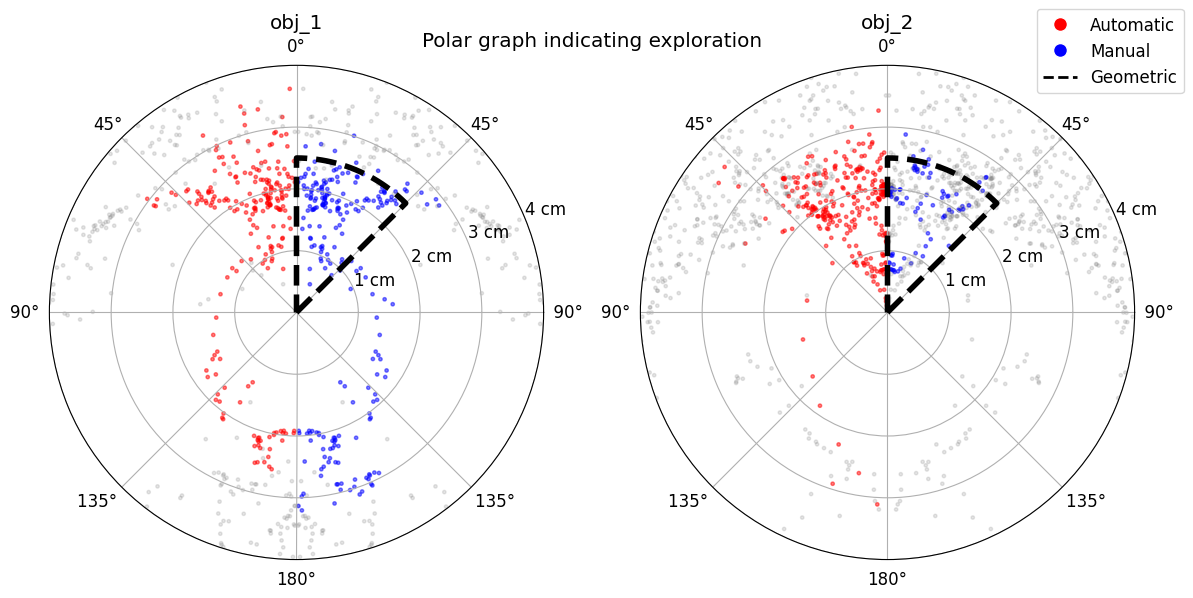

In [17]:
# Since the geometric and automatic labels are slightly shorter (due to the time when the mouse hasn't yet entered the arena), we need to remove the first few rows from the manual labels.
len_dif = len(example_manual_labels) - len(example_geolabels)
example_manual_labels = example_manual_labels.iloc[len_dif:].reset_index(drop=True)

rst.polar_graph(example_position, example_autolabels, example_manual_labels)

#### We can load all the data from all the available files and plot the polar graph again

In [18]:
# Create an empty list to store DataFrames
for_manual_labels = []
for_geolabels = []
for_autolabels = []
for_position = []

for i in range(len(TS_position)):

    df_position = pd.read_csv(TS_position[i])
    for_position.append(df_position)

    df_manual_labels = pd.read_csv(TS_manual_labels[i])
    len_dif = len(df_manual_labels) - len(df_position)
    df_manual_labels = df_manual_labels.iloc[len_dif:].reset_index(drop=True)
    for_manual_labels.append(df_manual_labels)

    df_geolabels = pd.read_csv(TS_geolabels[i])
    for_geolabels.append(df_geolabels)

    df_autolabels = pd.read_csv(TS_autolabels[i])
    for_autolabels.append(df_autolabels)
     

# Concatenate all DataFrames into a single DataFrame
all_manual_labels = pd.concat(for_manual_labels, ignore_index=True)
all_geolabels = pd.concat(for_geolabels, ignore_index=True)
all_autolabels = pd.concat(for_autolabels, ignore_index=True)
all_position = pd.concat(for_position, ignore_index=True)

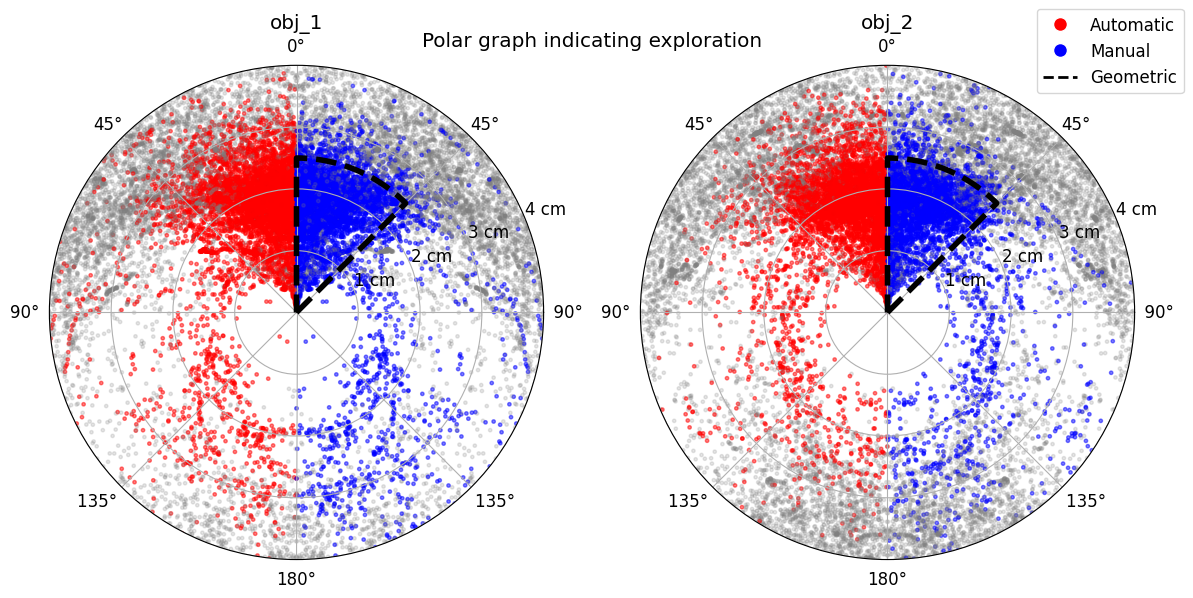

In [19]:
rst.polar_graph(all_position, all_autolabels, all_manual_labels) # This time it might take a few seconds

---
#### 6. Evaluate accuracy of predictions
Finally, we can evaluate the accuracy of the predictions by comparing the geometric and automatic labels to the manual labels.

In [20]:
rst.accuracy_scores(all_manual_labels, all_geolabels, "geometric")
rst.accuracy_scores(all_manual_labels, all_autolabels, "automatic", threshold=0.8)

Mice explored 6.96052070140267% of the time.
The geometric method measured 6.1152614005025505% of the time as exploration.
It got 25.96088352632091% of false negatives and 13.817261846842463% of false positives.
Mice explored 6.96052070140267% of the time.
The automatic method measured 6.201954662133331% of the time as exploration.
It got 22.847134377736694% of false negatives and 12.552301255230125% of false positives.


---
---
#### Both geometric and automatic methods are flawed when compared to human labeling. However, as the human responsible for the example manual labels provided, let me tell you that I too am flawed. Probably if more people labeled these videos and we compare against the average labels, we would have less error.

We can:
- Go to 5-Seize_labels.ipynb and use your favorite labels (geo, auto or manual) to plot the results of the experiment.

---
RAINSTORM - Created on Apr 18, 2024 - @author: Santiago D'hers